In [1]:
import math
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
import sklearn.metrics as sm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter



<h1>Anime Recommendor System</h1>

<p>
The purpose of our model is to recommend new anime to user based on the ones they have watched previously.
Our model takes the name of any anime as input and it will output a list of related animes.
The relevance is computed in two ways:
<p>

1. Similarity between anime based on the ratings they have receieved
2. Similarity between the users who have rated these animes.
We are using collaborative filtering to achieve this.
The first one is item-item similarity, in this case animes - we have 17558 animes in our data set
The second one is user-user similarity, we have 300k+ users in our data set who have rated one or more animes.


In [2]:
anime_data = pd.read_csv('anime.csv')
rating_data = pd.read_csv('rating_complete.csv')

<h5>For each anime we have the following features:</h5>
<pre>
- Genres that the anime fall into,
- English and Japaneese name of the anime,
- Number of episodes it has,
- When it was premiered and aired,
- The producers, licensors, studios and source,
- Duration, rating, popularity.
- Number of users who have the anime on Hold, are wacthing, completed, Dropped or plan to watch,
- And finally all animes are rated from 1-10 like IMDB ratings and we have data on each anime that how many users have given a particular rating to it.
- For example 1000 have rated it 5 10k have rated it 8 and so on.
</pre>
<hr>
<p>
    We also have data of each user mapped to each anime and what they have rated the anime: (user_id - anime_id) := rating
</p>

In [3]:
print(anime_data.columns)
print(rating_data.columns)
print(anime_data.shape)
print(len(anime_data['Name'].unique().tolist()))

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1'],
      dtype='object')
Index(['user_id', 'anime_id', 'rating'], dtype='object')
(17562, 35)
17558


In [4]:
print(rating_data.head())

   user_id  anime_id  rating
0        0       430       9
1        0      1004       5
2        0      3010       7
3        0       570       7
4        0      2762       9


Performing Analysis on dataset:

1. Number of users associated with a rating R
<!-- IMAGE 1 -->

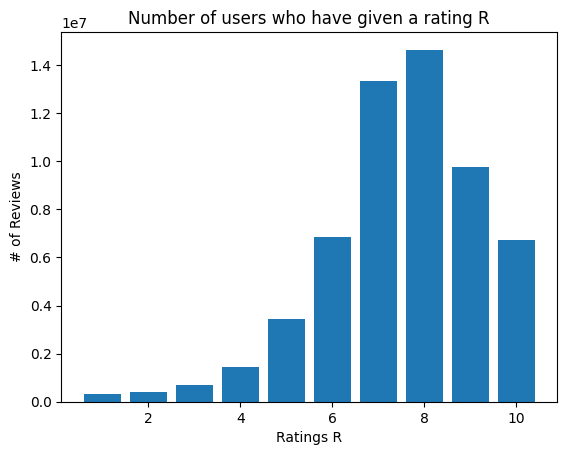

In [5]:
count_of_ratings = rating_data['rating'].value_counts()
plt.bar(x=count_of_ratings.index,height=count_of_ratings)
plt.xlabel('Ratings R')
plt.ylabel('# of Reviews')
plt.title('Number of users who have given a rating R')
plt.show()
#print(counts_of_ratings_by_users.median())
#print(counts_of_ratings_by_users.mean())
#print(counts_of_ratings_by_users.std())


2. Histogram of users and the number of animes they have rated.
<pre>Here we can see that most users (Almost 90%) have rated 1-200 animes

6k users have only rated 1 anime
2k have rated 5 animes
Most users have rated in the range of 1-200 as stated above among the 17k users
While there is one user who has rated 15k anime. (veteran anime watcher :) )
</pre>


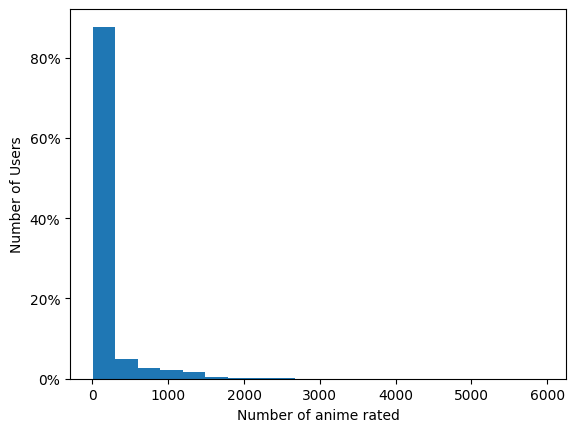

In [6]:
counts_of_ratings_by_users = rating_data['user_id'].value_counts()
#counts_of_ratings_by_users = rating_data['anime_id'].value_counts()
value_count_of_counts_user = counts_of_ratings_by_users.value_counts()
# plt.bar(value_count_of_counts_user.index, value_count_of_counts_user)

plt.hist(value_count_of_counts_user,bins=20,weights=np.ones(len(value_count_of_counts_user)) / len(value_count_of_counts_user))
plt.xlabel('Number of anime rated')
plt.ylabel('Number of Users')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

In [7]:
counts_of_ratings_by_users,value_count_of_counts_user

(189037    15455
 162615    14864
 68042     13462
 283786    12778
 259790     9996
           ...  
 201316        1
 201300        1
 97555         1
 201293        1
 137466        1
 Name: user_id, Length: 310059, dtype: int64,
 1        5952
 2        3913
 3        3335
 4        3017
 5        2662
          ... 
 2103        1
 2108        1
 2109        1
 2111        1
 15455       1
 Name: user_id, Length: 2354, dtype: int64)

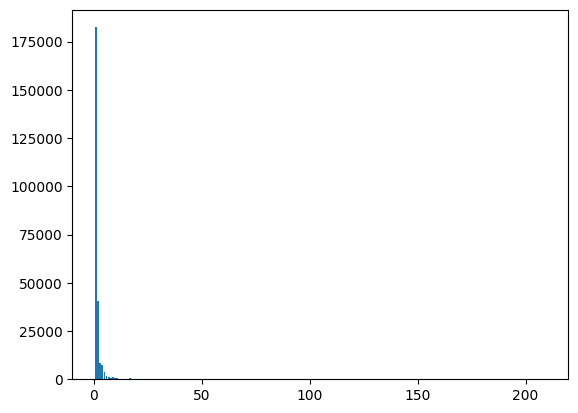

In [8]:
numbers_of_rating_for_anime = rating_data['anime_id'].value_counts().sort_values()
count_of_counts = numbers_of_rating_for_anime.value_counts().sort_index()
plt.bar(x=count_of_counts,height=count_of_counts.index)
plt.show()


In [9]:
number_of_users = rating_data['user_id'].unique().tolist()
print(len(number_of_users))
print(rating_data.shape)
ratings  = rating_data['rating'].unique().tolist()
print(ratings)

310059
(57633278, 3)
[9, 5, 7, 8, 10, 6, 4, 3, 2, 1]


In [10]:
anime_data = anime_data.rename(columns={"MAL_ID":"anime_id"})

Here you can see each anime is associated with more than one genre

In [11]:
anime_selected_column = anime_data[['anime_id','Name','Genres']]
anime_selected_column.head(20)

,anime_id,Name,Genres
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space"
1,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space"
2,6,Trigun,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen"
3,7,Witch Hunter Robin,"Action, Mystery, Police, Supernatural, Drama, ..."
4,8,Bouken Ou Beet,"Adventure, Fantasy, Shounen, Supernatural"
5,15,Eyeshield 21,"Action, Sports, Comedy, Shounen"
6,16,Hachimitsu to Clover,"Comedy, Drama, Josei, Romance, Slice of Life"
7,17,Hungry Heart: Wild Striker,"Slice of Life, Comedy, Sports, Shounen"
8,18,Initial D Fourth Stage,"Action, Cars, Sports, Drama, Seinen"
9,19,Monster,"Drama, Horror, Mystery, Police, Psychological,..."


<h2>Preproccesing</h2>

1. Check whether any anime or rating have missing values for columns - in our data there were no null values

In [12]:
print("Anime missing values (%):\n")
print(round(anime_selected_column.isnull().sum().sort_values(ascending=False)/len(anime_selected_column.index),4)*100) 

print("Rating missing values (%):\n")
print(round(rating_data.isnull().sum().sort_values(ascending=False)/len(rating_data.index),4)*100) 

anime_selected_column.info()
rating_data.info()

Anime missing values (%):

anime_id    0.0
Name        0.0
Genres      0.0
dtype: float64
Rating missing values (%):

user_id     0.0
anime_id    0.0
rating      0.0
dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17562 entries, 0 to 17561
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   anime_id  17562 non-null  int64 
 1   Name      17562 non-null  object
 2   Genres    17562 non-null  object
dtypes: int64(1), object(2)
memory usage: 411.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57633278 entries, 0 to 57633277
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 1.3 GB


2. Now we are only taking users that have made more than 400 ratings.
This is neccessary as the users who have extensively rated will have more similiarity. We don't want to take users who have made very few ratings as that doesn't represent the popular rating on the anime. This will help in giving more generalised data and will have focus on popularity among anime fans.
<br>
This reduces the number of users in our dataset to 35k.
<br>
Now we filter the anime rating data based on these selected users

In [13]:
counts = rating_data['user_id'].value_counts()
print(rating_data.shape)
selected_rating_data = rating_data[rating_data['user_id'].isin(counts[counts >= 400].index)]
selected_rating_data

(57633278, 3)


,user_id,anime_id,rating
1683,17,5781,7
1684,17,6682,10
1685,17,14199,2
1686,17,12355,6
1687,17,23673,6
...,...,...,...
57633028,353398,33421,6
57633029,353398,37007,4
57633030,353398,28825,6
57633031,353398,34028,3


In [14]:
anime_user_ratings = anime_selected_column.merge(selected_rating_data, left_on='anime_id', right_on='anime_id',how='right')

In [15]:
print(anime_user_ratings.columns, anime_user_ratings.shape)
uni_us = set()
for x in anime_user_ratings['user_id']:
    uni_us.add(x)
print("Number of users: ")
print(len(uni_us))

Index(['anime_id', 'Name', 'Genres', 'user_id', 'rating'], dtype='object') (24573682, 5)
Number of users: 
35292


In [16]:
anime_user_ratings.head()

,anime_id,Name,Genres,user_id,rating
0,5781,Isekai no Seikishi Monogatari,"Action, Comedy, Ecchi, Fantasy, Harem, Mecha, ...",17,7
1,6682,11eyes,"Action, Ecchi, Super Power, Supernatural",17,10
2,14199,Oniichan dakedo Ai sae Areba Kankeinai yo ne!,"Comedy, Ecchi, Harem, Romance, School",17,2
3,12355,Ookami Kodomo no Ame to Yuki,"Fantasy, Slice of Life",17,6
4,23673,Ookami Shoujo to Kuro Ouji,"Comedy, Romance, School, Shoujo",17,6


3. Anime  - User interaction matrix
<br>
Shape - (16844, 35292)
We have 16k Anime and 35k user ratings for each anime.

In [17]:
anime_pivot = anime_user_ratings.pivot_table(index='Name',columns='user_id',values='rating')
anime_pivot.head()
# print(anime_pivot.shape)

user_id,17,19,42,53,73,111,112,121,145,146,...,353304,353311,353318,353325,353326,353328,353357,353365,353395,353398
Name,,,,,,,,,,,,,,,,,,,,,
"""0""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"""Aesop"" no Ohanashi yori: Ushi to Kaeru, Yokubatta Inu",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"""Bungaku Shoujo"" Kyou no Oyatsu: Hatsukoi",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"""Bungaku Shoujo"" Memoire",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"""Bungaku Shoujo"" Movie",NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# 4. Next we normalize the ratings in the anime - user interaction matrix.
pivot_normalized = anime_pivot.apply(lambda x: (x-np.mean(x))/(np.max(x) - np.min(x)), axis=0)

# The NaN values in the matrix will be replaced with 0
pivot_normalized.fillna(0, inplace=True)

# The anime that has no rating will be removed
pivot_n1 = pivot_normalized.loc[:, (pivot_normalized != 0).any(axis=0)]

# Generate CSR matrix - since we need to efficiently process sparse matrix
piv_sparse1 = csr_matrix(pivot_n1.values)

<h2>
    Item - Item similarity
</h2>
The first step to to do item-item similarity is to find cosine similarity between animes

In [19]:
anime_similarity = cosine_similarity(piv_sparse1)

In [20]:
'''plt.imshow(anime_pivot, aspect='auto')
plt.title('Ratings Matrix');
plt.xlabel('Users');
plt.ylabel('Movies');'''

"plt.imshow(anime_pivot, aspect='auto')\nplt.title('Ratings Matrix');\nplt.xlabel('Users');\nplt.ylabel('Movies');"

<h3>Item - Item similarity matrix: <h3>

In [21]:
ani_sim = pd.DataFrame(anime_similarity, index = pivot_n1.index, columns = pivot_n1.index)
ani_sim

Name,"""0""","""Aesop"" no Ohanashi yori: Ushi to Kaeru, Yokubatta Inu","""Bungaku Shoujo"" Kyou no Oyatsu: Hatsukoi","""Bungaku Shoujo"" Memoire","""Bungaku Shoujo"" Movie","""Calpis"" Hakkou Monogatari","""Eiji""","""Eikou Naki Tensai-tachi"" Kara no Monogatari","""Eiyuu"" Kaitai","""Kinako"" Movie x Mameshiba",...,s.CRY.ed Alteration II: Quan,the FLY BanD!,xxxHOLiC,xxxHOLiC Kei,xxxHOLiC Movie: Manatsu no Yoru no Yume,xxxHOLiC Rou,xxxHOLiC Shunmuki,Üks Uks,ēlDLIVE,◯
Name,,,,,,,,,,,,,,,,,,,,,
"""0""",1.000000,0.019629,0.019226,-0.034730,-0.023543,0.113802,0.059813,0.043338,0.053125,0.067831,...,0.010449,0.014687,-0.046925,-0.044626,-0.045808,-0.049986,-0.042913,0.035668,0.014683,0.174267
"""Aesop"" no Ohanashi yori: Ushi to Kaeru, Yokubatta Inu",0.019629,1.000000,0.012524,0.019919,0.019815,-0.017112,0.037176,0.269131,0.047603,0.120686,...,0.018466,0.138033,-0.008111,0.009904,0.003380,-0.008854,0.017441,0.215527,0.008883,0.036992
"""Bungaku Shoujo"" Kyou no Oyatsu: Hatsukoi",0.019226,0.012524,1.000000,0.333865,0.206926,-0.008162,0.016483,0.017802,0.028743,-0.005315,...,0.014634,-0.008421,-0.016882,-0.028239,0.000138,-0.017029,-0.010669,-0.017963,0.020272,-0.014381
"""Bungaku Shoujo"" Memoire",-0.034730,0.019919,0.333865,1.000000,0.432366,-0.030120,-0.009535,-0.001095,-0.017852,-0.014404,...,0.011854,-0.045977,0.042004,0.039869,0.044951,0.051888,0.036106,-0.022274,-0.018467,-0.034241
"""Bungaku Shoujo"" Movie",-0.023543,0.019815,0.206926,0.432366,1.000000,-0.027846,-0.015293,0.006716,-0.012666,-0.017945,...,-0.003975,-0.021358,0.057875,0.062754,0.056918,0.061047,0.059589,-0.022313,-0.022279,-0.024532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
xxxHOLiC Rou,-0.049986,-0.008854,-0.017029,0.051888,0.061047,-0.030859,-0.012337,-0.008287,-0.036898,-0.015910,...,-0.017195,-0.029839,0.524379,0.634277,0.441705,1.000000,0.674817,-0.007684,-0.081764,-0.046554
xxxHOLiC Shunmuki,-0.042913,0.017441,-0.010669,0.036106,0.059589,-0.023758,-0.007602,0.006828,-0.031461,-0.006329,...,-0.020072,-0.014253,0.560471,0.645780,0.510363,0.674817,1.000000,-0.011433,-0.087524,-0.041435
Üks Uks,0.035668,0.215527,-0.017963,-0.022274,-0.022313,-0.014718,0.048187,0.233057,0.051114,0.184635,...,0.012670,-0.022130,-0.018387,-0.021075,-0.019434,-0.007684,-0.011433,1.000000,0.011427,0.113525


Anime recommendation using item-item similarity:

In [22]:
def anime_recommendation(anime_name):
    
    number = 1
    print(f'Similar Anime as {anime_name}\n')
    for anime in ani_sim.sort_values(by = anime_name, ascending = False).index[1:11]:
        print(f'#{number}: {anime}, {round(ani_sim[anime][anime_name]*100,2)}% match')
        number +=1  

<h3>Now that we have built the model, let's try to run it for anime - Naruto</h3>

In [23]:
anime_recommendation('Naruto')

Similar Anime as Naruto

#1: Naruto: Shippuuden, 43.32% match
#2: Bleach, 30.72% match
#3: Dragon Ball Z, 25.05% match
#4: Dragon Ball, 21.12% match
#5: Shingeki no Kyojin, 20.92% match
#6: Death Note, 20.16% match
#7: Naruto: Shippuuden Movie 1, 20.15% match
#8: The Last: Naruto the Movie, 20.14% match
#9: Shingeki no Kyojin Season 2, 20.09% match
#10: Fairy Tail, 20.07% match


<h2>User - User Similarity</h2>
Next we implement the model using user-user similarity.

In [24]:
anime_pivot

user_id,17,19,42,53,73,111,112,121,145,146,...,353304,353311,353318,353325,353326,353328,353357,353365,353395,353398
Name,,,,,,,,,,,,,,,,,,,,,
"""0""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"""Aesop"" no Ohanashi yori: Ushi to Kaeru, Yokubatta Inu",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"""Bungaku Shoujo"" Kyou no Oyatsu: Hatsukoi",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"""Bungaku Shoujo"" Memoire",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"""Bungaku Shoujo"" Movie",NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
xxxHOLiC Rou,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN
xxxHOLiC Shunmuki,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN
Üks Uks,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
# We will again use the anime - user interaction matrix to generate a new table.
# Here we are subtrating every rating with the average rating
pivot_normalized2 = anime_pivot.apply(lambda x: x-np.mean(x), axis=0)

# Replace NaN values with 0
pivot_normalized2.fillna(0,inplace=True)

# Transpose the generated matrix since we need user-user matrix
pivot_T = pivot_normalized2.T

# remove item/user with no rating
pivot_n2 = pivot_T.loc[:, (pivot_T != 0).any(axis=0)]

# Again use CSR
piv_sparse2 = csr_matrix(pivot_n2.values)

Calculate similarity betweeen users using Cosine similarity.

In [27]:
user_similarity = cosine_similarity(piv_sparse2)

In [28]:
user_similarity.shape,piv_sparse2.shape

((35292, 35292), (35292, 16838))

User - User similarity matrix: 

In [29]:
user_sim_df = pd.DataFrame(user_similarity, index = pivot_n2.index, columns = pivot_n2.index)
user_sim_df

user_id,17,19,42,53,73,111,112,121,145,146,...,353304,353311,353318,353325,353326,353328,353357,353365,353395,353398
user_id,,,,,,,,,,,,,,,,,,,,,
17,1.000000,0.037767,0.080325,0.030698,0.055056,0.057561,0.057338,0.022757,0.084999,0.015857,...,0.047401,0.061084,0.072863,0.024033,0.123998,0.021505,0.035223,0.083929,0.063163,0.029151
19,0.037767,1.000000,0.016123,0.099996,0.075880,0.077153,0.098907,0.040946,0.129734,0.049713,...,0.060356,0.034499,0.091492,0.008459,0.153315,0.032581,0.060215,0.060610,0.083465,0.083153
42,0.080325,0.016123,1.000000,0.005624,0.060814,0.024837,-0.020126,0.052903,0.046098,0.065828,...,0.000550,0.023911,0.029123,0.005293,0.072411,0.065050,-0.006013,0.025882,0.028632,-0.017561
53,0.030698,0.099996,0.005624,1.000000,0.036718,0.063260,0.067903,0.020530,0.110362,0.035104,...,0.106550,0.024443,0.134707,-0.004038,0.098997,0.058045,0.046960,0.059194,0.062203,0.026474
73,0.055056,0.075880,0.060814,0.036718,1.000000,0.103762,0.054390,0.030773,0.157697,0.067604,...,0.093931,0.050250,0.141546,-0.020461,0.193597,0.054865,0.056085,0.110818,0.120648,0.061924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353328,0.021505,0.032581,0.065050,0.058045,0.054865,0.029460,0.218825,0.049385,0.051520,0.009922,...,0.151397,0.020033,0.037698,0.015357,0.065185,1.000000,0.135917,0.017518,0.106701,-0.004641
353357,0.035223,0.060215,-0.006013,0.046960,0.056085,0.044851,0.194659,0.051697,0.079330,0.028946,...,0.136288,0.021487,0.054429,-0.000195,0.076344,0.135917,1.000000,0.011972,0.110088,0.043134
353365,0.083929,0.060610,0.025882,0.059194,0.110818,0.062240,0.070891,0.031503,0.062798,0.006920,...,0.041770,0.089343,0.121250,0.006421,0.126220,0.017518,0.011972,1.000000,0.051950,0.063390


<h3>Find new Animes from the animes that users with similar taste as the user in spotlight has</h3>

<pre>
We will find 10 users that have most similar taste for each user.
For example, here we are taking a user with id 17 and we find the top 10 users that have similar taste.
Then we will look at the animes that those 10 users have watched and rated. We remove the animes that user_id 17 has watched from that anime list.
Now we have new animes for user 17 that the user has not watched.
From these animes using user_id 17 and the 10 users we will predict the ratings for each of the new animes.
Then we will suggest the top 10 animes from these list to the user
</pre>


In [30]:
# Find 10 users that have similar taste to 17
userid = 17
Number_of_similar_Users = 10
threshold = 0.1
similar_users_to_userid = user_sim_df[user_sim_df[userid] >threshold][userid].sort_values(ascending=False)[1:Number_of_similar_Users+1]
similar_users_to_userid

/var/folders/7l/631vswv51c99236gtb8lhpyw0000gn/T/ipykernel_8539/2679034399.py:5: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  similar_users_to_userid = user_sim_df[user_sim_df[userid] >threshold][userid].sort_values(ascending=False)[1:Number_of_similar_Users+1]


user_id
279757    0.204531
70022     0.200061
74759     0.199011
20468     0.196432
259986    0.194538
156246    0.194157
26049     0.192727
169945    0.191587
115315    0.188445
251874    0.187222
Name: 17, dtype: float64

In [31]:
pivot_n2

Name,"""0""","""Aesop"" no Ohanashi yori: Ushi to Kaeru, Yokubatta Inu","""Bungaku Shoujo"" Kyou no Oyatsu: Hatsukoi","""Bungaku Shoujo"" Memoire","""Bungaku Shoujo"" Movie","""Calpis"" Hakkou Monogatari","""Eiji""","""Eikou Naki Tensai-tachi"" Kara no Monogatari","""Eiyuu"" Kaitai","""Kinako"" Movie x Mameshiba",...,s.CRY.ed Alteration II: Quan,the FLY BanD!,xxxHOLiC,xxxHOLiC Kei,xxxHOLiC Movie: Manatsu no Yoru no Yume,xxxHOLiC Rou,xxxHOLiC Shunmuki,Üks Uks,ēlDLIVE,◯
user_id,,,,,,,,,,,,,,,,,,,,,
17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
53,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.229209,2.229209,-1.770791,1.229209,1.229209,0.0,0.000000,0.000000
73,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353328,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,-2.066202
353357,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
353365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000


In [32]:
# Animes that the target user has watched
picked_userid_watched = pivot_n2[pivot_n2.index == userid].loc[:, (pivot_n2[pivot_n2.index == userid] != 0).any(axis=0)]
picked_userid_watched

Name,07-Ghost,11eyes,91 Days,AIKa R-16: Virgin Mission,AIKa Zero,Absolute Duo,Accel World,Acchi Kocchi (TV),Ai wa KAT-TUN,Air Gear,...,Zero kara Hajimeru Mahou no Sho,Zero no Tsukaima,Zero no Tsukaima F,Zero no Tsukaima: Futatsuki no Kishi,Zero no Tsukaima: Princesses no Rondo,Zetman,Zetsuen no Tempest,Zettai Bouei Leviathan,Zombie-Loan,ef: A Tale of Memories.
user_id,,,,,,,,,,,,,,,,,,,,,
17,-1.863188,3.136812,2.136812,-0.863188,-1.863188,-0.863188,2.136812,-4.863188,-4.863188,-2.863188,...,1.136812,3.136812,3.136812,3.136812,3.136812,-3.863188,3.136812,-2.863188,2.136812,-0.863188


In [33]:
# Remove animes that none of the similar users have watched
similar_user_df = pivot_n2[pivot_n2.index.isin(similar_users_to_userid.index)]
similar_user_movies = similar_user_df.loc[:,(similar_user_df !=0).any(axis=0)]
similar_user_movies

Name,.hack//G.U. Trilogy,.hack//Quantum,.hack//Roots,.hack//Sign,.hack//Tasogare no Udewa Densetsu,009 Re:Cyborg,07-Ghost,11eyes,11eyes: Momoiro Genmutan,18if,...,Zoku Natsume Yuujinchou,Zombie-Loan,Zombieland Saga,Zutto Mae kara Suki deshita.: Kokuhaku Jikkou Iinkai,ef: A Tale of Melodies.,ef: A Tale of Memories.,s.CRY.ed,xxxHOLiC,xxxHOLiC Kei,ēlDLIVE
user_id,,,,,,,,,,,,,,,,,,,,,
20468,0.000000,0.000000,-1.553846,0.000000,-1.553846,0.000000,-1.553846,-1.553846,-2.553846,0.000000,...,0.000000,-0.553846,0.000000,0.446154,0.000000,0.000000,0.000000,0.446154,0.446154,-1.553846
26049,0.000000,0.000000,0.000000,0.000000,0.000000,-1.392491,0.607509,0.607509,-1.392491,-0.392491,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
70022,-0.565292,-0.565292,0.000000,-0.565292,-0.565292,0.000000,-0.565292,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,2.434708,0.434708,0.000000,0.000000,0.000000,0.000000
74759,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.645923,0.000000,0.000000,...,0.000000,0.000000,-0.645923,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
115315,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.782435,0.000000,0.000000,0.000000,0.000000,0.000000,-2.217565,0.000000,0.000000,0.000000
156246,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.519231
169945,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.322581,-0.322581,0.000000,...,1.677419,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
251874,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.314118,-5.314118,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
259986,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.989280,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.989280


In [34]:
s1 = similar_user_df.loc[:,(similar_user_df !=0).any(axis=0)]
similar_user_movies2 = similar_user_df.loc[:,(similar_user_df !=0).any(axis=0)]
#remove animes that picked user has watched
s1.drop(picked_userid_watched.columns,axis=1, inplace=True, errors='ignore')

similar_user_movies2.drop(s1.columns,axis=1,inplace = True,errors= 'ignore')
similar_user_movies2

/var/folders/7l/631vswv51c99236gtb8lhpyw0000gn/T/ipykernel_8539/880768317.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s1.drop(picked_userid_watched.columns,axis=1, inplace=True, errors='ignore')
/var/folders/7l/631vswv51c99236gtb8lhpyw0000gn/T/ipykernel_8539/880768317.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  similar_user_movies2.drop(s1.columns,axis=1,inplace = True,errors= 'ignore')


Name,07-Ghost,11eyes,91 Days,AIKa R-16: Virgin Mission,AIKa Zero,Absolute Duo,Accel World,Acchi Kocchi (TV),Air Gear,Aiura,...,Zero kara Hajimeru Mahou no Sho,Zero no Tsukaima,Zero no Tsukaima F,Zero no Tsukaima: Futatsuki no Kishi,Zero no Tsukaima: Princesses no Rondo,Zetman,Zetsuen no Tempest,Zettai Bouei Leviathan,Zombie-Loan,ef: A Tale of Memories.
user_id,,,,,,,,,,,,,,,,,,,,,
20468,-1.553846,-1.553846,0.000000,0.000000,0.000000,0.446154,2.446154,0.000000,-0.553846,0.00000,...,0.000000,1.446154,1.446154,1.446154,1.446154,1.446154,0.446154,-2.553846,-0.553846,0.000000
26049,0.607509,0.607509,0.000000,0.000000,0.000000,-2.392491,0.607509,0.000000,-0.392491,0.00000,...,0.607509,0.607509,0.607509,0.607509,0.607509,-1.392491,0.607509,0.000000,0.000000,0.000000
70022,-0.565292,0.000000,0.000000,0.000000,0.000000,0.000000,0.434708,-0.565292,-0.565292,0.00000,...,0.000000,0.434708,1.434708,0.434708,0.434708,0.000000,0.434708,-0.565292,0.000000,0.434708
74759,0.000000,-0.645923,1.354077,0.000000,0.000000,0.000000,0.354077,0.000000,1.354077,0.00000,...,0.000000,1.354077,1.354077,1.354077,1.354077,0.354077,1.354077,0.000000,0.000000,0.000000
115315,0.000000,0.000000,0.000000,0.000000,0.000000,-0.217565,2.782435,-1.217565,0.000000,0.00000,...,0.000000,-0.217565,0.782435,0.782435,-0.217565,0.000000,2.782435,0.000000,0.000000,0.000000
156246,0.000000,0.000000,0.000000,0.000000,0.000000,-1.519231,0.000000,0.000000,0.480769,0.00000,...,0.000000,-0.519231,-0.519231,-0.519231,-0.519231,0.000000,1.480769,0.000000,0.000000,0.000000
169945,0.000000,-1.322581,0.000000,-0.322581,-0.322581,0.000000,-1.322581,0.677419,-0.322581,0.00000,...,0.000000,0.677419,0.677419,0.677419,0.677419,-1.322581,1.677419,0.000000,0.000000,0.000000
251874,0.000000,-3.314118,0.000000,0.000000,0.000000,-0.314118,3.685882,0.000000,2.685882,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
259986,0.000000,0.000000,-0.989280,0.000000,0.000000,0.010720,1.010720,0.000000,0.000000,-1.98928,...,0.010720,-1.989280,-0.989280,0.010720,-1.989280,0.000000,0.000000,0.000000,0.000000,0.000000


In [35]:
# Remove the watched movie from the movie list
similar_user_movies.drop(picked_userid_watched.columns,axis=1, inplace=True, errors='ignore')
# Take a look at the data
similar_user_movies


/var/folders/7l/631vswv51c99236gtb8lhpyw0000gn/T/ipykernel_8539/521465360.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  similar_user_movies.drop(picked_userid_watched.columns,axis=1, inplace=True, errors='ignore')


Name,.hack//G.U. Trilogy,.hack//Quantum,.hack//Roots,.hack//Sign,.hack//Tasogare no Udewa Densetsu,009 Re:Cyborg,11eyes: Momoiro Genmutan,18if,3-gatsu no Lion,30-sai no Hoken Taiiku,...,Zoids,Zoids Genesis,Zoku Natsume Yuujinchou,Zombieland Saga,Zutto Mae kara Suki deshita.: Kokuhaku Jikkou Iinkai,ef: A Tale of Melodies.,s.CRY.ed,xxxHOLiC,xxxHOLiC Kei,ēlDLIVE
user_id,,,,,,,,,,,,,,,,,,,,,
20468,0.000000,0.000000,-1.553846,0.000000,-1.553846,0.000000,-2.553846,0.000000,0.446154,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.446154,0.000000,0.000000,0.446154,0.446154,-1.553846
26049,0.000000,0.000000,0.000000,0.000000,0.000000,-1.392491,-1.392491,-0.392491,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
70022,-0.565292,-0.565292,0.000000,-0.565292,-0.565292,0.000000,0.000000,0.000000,0.000000,-0.565292,...,-1.565292,-1.565292,0.000000,0.000000,0.000000,2.434708,0.000000,0.000000,0.000000,0.000000
74759,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-0.645923,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
115315,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.782435,0.000000,0.000000,0.000000,-2.217565,0.000000,0.000000,0.000000
156246,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.519231
169945,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.322581,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.677419,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
251874,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-5.314118,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
259986,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.989280,0.000000,1.010720,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.989280


<p>
    Now that we have the list of new animes to suggest to user we will predict the rating (anime_score) for each anime and then select the top 10 rated animes from this new anime list
<p>

In [36]:
item_score = {}

for i in similar_user_movies.columns:
  movie_rating = similar_user_movies[i]
  total = 0
  total_sim = 0
  for u in similar_users_to_userid.index:
    if movie_rating[u] !=0:
      score = similar_users_to_userid[u]*movie_rating[u]
      total += score
      total_sim += similar_users_to_userid[u]
  item_score[i] = total / total_sim

item_score = pd.DataFrame(item_score.items(),columns=['Anime','Anime_score'])

ranked_item_score = item_score.sort_values(by='Anime_score',ascending=False)
ranked_item_score.head(10)

,Anime,Anime_score
1517,The Embryo Develops into a Fetus,3.685882
86,Ano Hi Mita Hana no Namae wo Bokutachi wa Mada...,3.685882
1489,Tengen Toppa Gurren Lagann Movie 2: Lagann-hen,3.685882
1158,Persona 3 the Movie 4: Winter of Rebirth,2.782435
609,Hunter x Hunter: Original Video Animation,2.685882
1112,Ongaku Shoujo,2.685882
906,Mahou Shoujo Madoka★Magica Movie 3: Hangyaku n...,2.588735
1344,Shelter,2.539135
324,Digimon Adventure tri. 1: Saikai,2.539135
990,Monogatari Series: Second Season,2.528700


Find average rating for the selected users based on the animes they watched previously

In [37]:
# Average rating for the picked user
avg_rating = anime_pivot[userid].mean()
avg_rating


6.863187588152328

Now we add the average rating to these new anime since we removed it earlier in the matrix
If we hadn't removed the average rating earlier for normalization, then we should add the actual rating to the score

In [38]:
ranked_item_score['predicted_rating'] = np.floor(ranked_item_score['Anime_score'] + avg_rating)
# Take a look at the data
ranked_item_score.head(10)

,Anime,Anime_score,predicted_rating
1517,The Embryo Develops into a Fetus,3.685882,10.0
86,Ano Hi Mita Hana no Namae wo Bokutachi wa Mada...,3.685882,10.0
1489,Tengen Toppa Gurren Lagann Movie 2: Lagann-hen,3.685882,10.0
1158,Persona 3 the Movie 4: Winter of Rebirth,2.782435,9.0
609,Hunter x Hunter: Original Video Animation,2.685882,9.0
1112,Ongaku Shoujo,2.685882,9.0
906,Mahou Shoujo Madoka★Magica Movie 3: Hangyaku n...,2.588735,9.0
1344,Shelter,2.539135,9.0
324,Digimon Adventure tri. 1: Saikai,2.539135,9.0
990,Monogatari Series: Second Season,2.528700,9.0


In [48]:
pivot_n2_train,pivot_n2_test = train_test_split(pivot_n2,test_size=0.3)

In [47]:
pivot_n2.shape[0]

35292

In [54]:
pivot_n2_train

Name,"""0""","""Aesop"" no Ohanashi yori: Ushi to Kaeru, Yokubatta Inu","""Bungaku Shoujo"" Kyou no Oyatsu: Hatsukoi","""Bungaku Shoujo"" Memoire","""Bungaku Shoujo"" Movie","""Calpis"" Hakkou Monogatari","""Eiji""","""Eikou Naki Tensai-tachi"" Kara no Monogatari","""Eiyuu"" Kaitai","""Kinako"" Movie x Mameshiba",...,s.CRY.ed Alteration II: Quan,the FLY BanD!,xxxHOLiC,xxxHOLiC Kei,xxxHOLiC Movie: Manatsu no Yoru no Yume,xxxHOLiC Rou,xxxHOLiC Shunmuki,Üks Uks,ēlDLIVE,◯
user_id,,,,,,,,,,,,,,,,,,,,,
3941,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
256073,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
338596,0.0,0.0,-0.431416,0.0,2.568584,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
286406,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
123436,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232494,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
176267,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
140810,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
pivot_n2_test

Name,"""0""","""Aesop"" no Ohanashi yori: Ushi to Kaeru, Yokubatta Inu","""Bungaku Shoujo"" Kyou no Oyatsu: Hatsukoi","""Bungaku Shoujo"" Memoire","""Bungaku Shoujo"" Movie","""Calpis"" Hakkou Monogatari","""Eiji""","""Eikou Naki Tensai-tachi"" Kara no Monogatari","""Eiyuu"" Kaitai","""Kinako"" Movie x Mameshiba",...,s.CRY.ed Alteration II: Quan,the FLY BanD!,xxxHOLiC,xxxHOLiC Kei,xxxHOLiC Movie: Manatsu no Yoru no Yume,xxxHOLiC Rou,xxxHOLiC Shunmuki,Üks Uks,ēlDLIVE,◯
user_id,,,,,,,,,,,,,,,,,,,,,
28535,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.050000,1.950000,0.000000,-0.050000,-2.050000,0.0,0.0,0.0
312416,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.424217,2.424217,3.424217,3.424217,2.424217,0.0,0.0,0.0
342820,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
183388,0.0,0.0,-0.793245,0.0,-0.793245,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.206755,1.206755,1.206755,0.000000,1.206755,0.0,0.0,0.0
314608,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45009,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
14995,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
254401,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0


In [39]:
def similar_users(userid, Number_of_similar_Users=10):
  return user_sim_df[user_sim_df[userid] >threshold][userid].sort_values(ascending=False)[1:Number_of_similar_Users+1]

def recommend_movies(userid):
  #similar users to user id 
  similar_users_to_userid = similar_users(userid)
  # Movies that the target user has watched
  picked_userid_watched = pivot_n2[pivot_n2.index == userid].loc[:, (pivot_n2[pivot_n2.index == userid] != 0).any(axis=0)]
  # Remove movies that none of the similar users have watched
  similar_user_df = pivot_n2[pivot_n2.index.isin(similar_users_to_userid.index)]
  similar_user_movies = similar_user_df.loc[:,(similar_user_df !=0).any(axis=0)]
  
  #remove movies that picked user has watched
  similar_user_movies.drop(picked_userid_watched.columns,axis=1, inplace=True, errors='ignore')

  item_score = {}

  for i in similar_user_movies.columns:
    movie_rating = similar_user_movies[i]
    total = 0
    total_sim = 0
    for u in similar_users_to_userid.index:
      if movie_rating[u] !=0:
        score = similar_users_to_userid[u]*movie_rating[u]
        total += score
        total_sim += similar_users_to_userid[u]
    item_score[i] = total / total_sim

  item_score = pd.DataFrame(item_score.items(),columns=['Movie','Movie_score'])

  ranked_item_score = item_score.sort_values(by='Movie_score',ascending=False)
  
  # Average rating for the picked user
  avg_rating = anime_pivot[userid].mean()

  ranked_item_score['predicted_rating'] = np.floor(ranked_item_score['Movie_score'] + avg_rating)
  return ranked_item_score.head(10)

Lets try for user 346

In [40]:
recommend_movies(346)

/var/folders/7l/631vswv51c99236gtb8lhpyw0000gn/T/ipykernel_8539/2320563193.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return user_sim_df[user_sim_df[userid] >threshold][userid].sort_values(ascending=False)[1:Number_of_similar_Users+1]
/var/folders/7l/631vswv51c99236gtb8lhpyw0000gn/T/ipykernel_8539/2320563193.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  similar_user_movies.drop(picked_userid_watched.columns,axis=1, inplace=True, errors='ignore')


,Movie,Movie_score,predicted_rating
2305,Senki Zesshou Symphogear XV,2.755003,10.0
806,Gintama°,2.732740,10.0
2989,xxxHOLiC Rou,2.620557,10.0
1154,Itazura na Kiss,2.620557,10.0
1341,Kimi no Suizou wo Tabetai,2.363988,10.0
1340,Kimi no Na wa.,2.347690,10.0
2761,Uchuu Senkan Yamato 2199,2.078303,10.0
2607,Tenki no Ko,2.051540,10.0
1833,No Game No Life: Zero,2.018830,10.0
2413,Shouwa Genroku Rakugo Shinjuu: Sukeroku Futata...,2.007693,10.0


<pre>
Now we want to check how accurate our prediction is:
For this we find ratings for animes based on similarity for the users that have already rated it.
</pre>

In [41]:
def find_rating_for_same_movies(userid):
  #similar users to user id 
  similar_users_to_userid = similar_users(userid)
  # Movies that the target user has watched
  picked_userid_watched = pivot_n2[pivot_n2.index == userid].loc[:, (pivot_n2[pivot_n2.index == userid] != 0).any(axis=0)]
  # Remove movies that none of the similar users have watched
  similar_user_df = pivot_n2[pivot_n2.index.isin(similar_users_to_userid.index)]
  s1 = similar_user_df.loc[:,(similar_user_df !=0).any(axis=0)]
  similar_user_movies = similar_user_df.loc[:,(similar_user_df !=0).any(axis=0)]
  #remove movies that picked user has watched
  s1.drop(picked_userid_watched.columns,axis=1, inplace=True, errors='ignore')

  similar_user_movies.drop(s1.columns,axis=1,inplace = True,errors= 'ignore')

  item_score = {}

  for i in similar_user_movies.columns:
    movie_rating = similar_user_movies[i]
    total = 0
    total_sim = 0
    for u in similar_users_to_userid.index:
      if movie_rating[u] !=0:
        score = similar_users_to_userid[u]*movie_rating[u]
        total += score
        total_sim += similar_users_to_userid[u]
    item_score[i] = total / total_sim

  item_score = pd.DataFrame(item_score.items(),columns=['Anime','Anime_score'])

  ranked_item_score = item_score#item_score.sort_values(by='Anime_score',ascending=False)
  
  # Average rating for the picked user
  avg_rating = anime_pivot[userid].mean()

  ranked_item_score['predicted_rating'] = ranked_item_score['Anime_score'] + avg_rating
  return ranked_item_score

In [42]:
temp = find_rating_for_same_movies(314)
temp

/var/folders/7l/631vswv51c99236gtb8lhpyw0000gn/T/ipykernel_8539/2320563193.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return user_sim_df[user_sim_df[userid] >threshold][userid].sort_values(ascending=False)[1:Number_of_similar_Users+1]
/var/folders/7l/631vswv51c99236gtb8lhpyw0000gn/T/ipykernel_8539/1971308988.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s1.drop(picked_userid_watched.columns,axis=1, inplace=True, errors='ignore')
/var/folders/7l/631vswv51c99236gtb8lhpyw0000gn/T/ipykernel_8539/1971308988.py:13: SettingWithCopyWarning: 

,Anime,Anime_score,predicted_rating
0,11eyes,-0.786821,7.355063
1,11eyes: Momoiro Genmutan,-1.174835,6.967049
2,3-gatsu no Lion,-0.161067,7.980817
3,30-sai no Hoken Taiiku,-1.492752,6.649132
4,Aa! Megami-sama! (TV),0.663970,8.805854
...,...,...,...
673,Zetman,-0.347253,7.794631
674,Zetsuen no Tempest,1.193634,9.335518
675,Zombie-Loan,-0.979752,7.162132
676,Zombie-Loan Specials,-0.364583,7.777301


Actual rating of the anime

In [43]:
y_true = anime_pivot.loc[anime_pivot.index.isin( temp['Anime'])][314].values
y_true

array([ 7.,  6.,  8.,  8.,  9.,  9.,  8.,  9.,  9.,  7.,  7., 10.,  8.,
        9.,  8.,  9.,  8.,  9.,  9.,  8.,  9.,  8.,  9.,  9.,  9.,  9.,
        8.,  8.,  7.,  7.,  9., 10.,  6.,  9., 10.,  8.,  9.,  9.,  8.,
        8.,  7.,  7.,  9.,  9.,  8.,  7., 10.,  8.,  7.,  7.,  8., 10.,
       10.,  7.,  7.,  8.,  8.,  9.,  6., 10., 10.,  8.,  8.,  8.,  9.,
        8.,  9.,  8.,  9., 10.,  9.,  8.,  8.,  8.,  6.,  6.,  8.,  7.,
        7., 10.,  8.,  8.,  9.,  9.,  7.,  9.,  8.,  8.,  8.,  9.,  8.,
       10., 10., 10., 10., 10., 10.,  9.,  7.,  7.,  8., 10.,  7., 10.,
        7.,  9.,  8.,  8.,  5.,  8.,  8.,  7.,  9., 10.,  8., 10.,  8.,
        9.,  9., 10.,  5., 10.,  9.,  9.,  7.,  7.,  8.,  5.,  8.,  8.,
        7.,  6.,  6., 10.,  8.,  7.,  7.,  8.,  8.,  8.,  8.,  8.,  8.,
        8.,  8.,  7.,  8.,  7.,  8.,  9.,  8.,  8.,  7., 10.,  5.,  8.,
        8.,  8., 10.,  7.,  7., 10.,  8.,  9.,  8., 10.,  8.,  9.,  8.,
        8.,  8.,  8.,  8.,  8.,  8.,  6., 10., 10.,  8.,  8.,  9

predicted rating for the animes

In [44]:
y_pred = temp['predicted_rating'].values
y_pred

array([ 7.35506322,  6.96704893,  7.98081725,  6.64913249,  8.80585376,
        8.07752469,  6.76356816,  9.42393846,  9.31978011,  7.1599589 ,
        8.81192637,  8.46166279,  7.52286858,  8.24715586,  7.29383623,
        7.48038999,  8.18892118,  8.143561  ,  8.37250561,  8.37250561,
        7.10754946,  7.7816861 ,  7.68926507,  9.23752421,  6.8683993 ,
        9.57574895,  7.09547652,  8.06218113,  7.69309976,  5.12082305,
        9.64824648,  8.25486726,  8.07150306,  7.10754946,  9.79573939,
        9.40436929,  8.82856631,  9.32589918,  8.94982073,  9.21401935,
        8.08585483,  7.80207632,  9.53108163,  8.52628971,  8.81957337,
        6.97230784,  8.8521086 ,  6.26576292,  5.66602107,  7.94298477,
        8.00978333,  8.82503346,  8.90950779,  6.99217166,  7.62738781,
        8.64596553,  8.25890282,  9.00371696,  7.34280603,  8.72532443,
        8.0784564 ,  8.74207295,  9.05908099,  8.47112078,  9.41181808,
        9.62192091,  9.91543044,  9.88599034,  7.80681115, 10.03

Now we find the mean squared error for a particular user to check model accuracy

In [45]:
mean_squared_error(y_true=y_true,y_pred=y_pred)

1.2161703043879364

In [46]:

print("Mean absolute error =", round(sm.mean_absolute_error(y_true, y_pred), 2)) 
print("Mean squared error =", round(sm.mean_squared_error(y_true, y_pred), 2)) 
print("Median absolute error =", round(sm.median_absolute_error(y_true, y_pred), 2)) 

Mean absolute error = 0.86
Mean squared error = 1.22
Median absolute error = 0.74


Split the data into train and test data - Training has 70% users and remaining 30% is in testing data

In [51]:
user_sim_df2 = user_sim_df.loc[user_sim_df.index.isin(pivot_n2_test.index),pivot_n2_train.index]
# user_sim_df2.loc[user_sim_df2.index.isin(pivot_n2_test.index),pivot_n2_train.index
user_sim_df2

user_id,3941,256073,338596,286406,123436,215985,145592,325728,31386,162916,...,275800,40997,231522,96600,348343,232494,176267,140810,86053,155736
user_id,,,,,,,,,,,,,,,,,,,,,
73,0.107404,0.085769,0.070997,0.088310,0.104527,0.090290,0.047907,0.104210,0.060032,0.045689,...,0.039475,0.127929,0.123068,0.049053,0.087083,0.077415,0.009801,0.176885,0.023254,0.114587
146,0.043375,0.056162,0.073385,0.020932,0.056179,0.076926,0.035172,0.072312,0.113375,0.025260,...,0.025248,0.073751,0.033881,0.072139,0.110804,0.043415,-0.013269,0.099554,0.004525,0.020943
147,0.073925,0.015221,0.075120,0.061879,0.075464,0.090238,0.015606,0.056562,0.073784,-0.010299,...,0.031501,0.098502,0.021440,0.066639,0.113441,0.008266,0.000000,0.075026,0.061918,0.079719
156,0.061896,0.054949,0.072945,0.089479,0.089413,0.155653,0.054231,0.087789,0.060356,0.009399,...,0.140623,0.090863,0.067293,0.095426,0.061107,0.050983,-0.015907,0.080403,0.155858,0.130415
172,0.100913,0.097561,0.079712,0.050069,0.114464,0.155651,0.112110,0.179053,0.107902,0.022483,...,0.033703,0.186132,0.079318,0.112259,0.157013,0.067342,0.000000,0.212070,0.021991,0.055284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353153,0.065054,0.087182,0.086716,0.066885,0.096126,0.138970,0.067920,0.114090,0.098516,0.072400,...,0.016502,0.139652,0.126798,0.109658,0.102073,0.102419,-0.001212,0.176616,0.020853,0.093864
353175,0.107822,0.007551,0.123494,0.107489,0.128699,0.133824,0.014636,0.197200,0.108481,0.057070,...,0.090219,0.136674,0.095378,0.077544,0.089484,0.077739,0.000000,0.117620,0.124263,0.117859
353201,0.094157,0.069239,0.099610,0.041112,0.103391,0.123548,0.025998,0.083067,0.150591,0.046518,...,0.088791,0.241089,0.117190,0.055139,0.115569,0.076897,0.000000,0.198928,0.050789,0.089982


In [52]:
def similar_users_test(userid, Number_of_similar_Users=10):
  return user_sim_df2[user_sim_df2[userid] >threshold][userid].sort_values(ascending=False)[1:Number_of_similar_Users+1]

def find_rating_for_same_movies_test(userid):
  #similar users to user id 
  similar_users_to_userid = similar_users(userid)
  # Movies that the target user has watched
  picked_userid_watched = pivot_n2[pivot_n2.index == userid].loc[:, (pivot_n2[pivot_n2.index == userid] != 0).any(axis=0)]
  # Remove movies that none of the similar users have watched
  similar_user_df = pivot_n2[pivot_n2.index.isin(similar_users_to_userid.index)]
  s1 = similar_user_df.loc[:,(similar_user_df !=0).any(axis=0)]
  similar_user_movies = similar_user_df.loc[:,(similar_user_df !=0).any(axis=0)]
  #remove movies that picked user has watched
  s1.drop(picked_userid_watched.columns,axis=1, inplace=True, errors='ignore')

  similar_user_movies.drop(s1.columns,axis=1,inplace = True,errors= 'ignore')

  item_score = {}

  for i in similar_user_movies.columns:
    movie_rating = similar_user_movies[i]
    total = 0
    total_sim = 0
    for u in similar_users_to_userid.index:
      if movie_rating[u] !=0:
        score = similar_users_to_userid[u]*movie_rating[u]
        total += score
        total_sim += similar_users_to_userid[u]
    item_score[i] = total / total_sim

  item_score = pd.DataFrame(item_score.items(),columns=['Anime','Anime_score'])

  ranked_item_score = item_score#item_score.sort_values(by='Anime_score',ascending=False)
  
  # Average rating for the picked user
  avg_rating = anime_pivot[userid].mean()

  ranked_item_score['predicted_rating'] = ranked_item_score['Anime_score'] + avg_rating
  return ranked_item_score

In [53]:
find_rating_for_same_movies_test(478)

/var/folders/7l/631vswv51c99236gtb8lhpyw0000gn/T/ipykernel_8539/2320563193.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return user_sim_df[user_sim_df[userid] >threshold][userid].sort_values(ascending=False)[1:Number_of_similar_Users+1]
/var/folders/7l/631vswv51c99236gtb8lhpyw0000gn/T/ipykernel_8539/1250144678.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s1.drop(picked_userid_watched.columns,axis=1, inplace=True, errors='ignore')
/var/folders/7l/631vswv51c99236gtb8lhpyw0000gn/T/ipykernel_8539/1250144678.py:16: SettingWithCopyWarning: 

,Anime,Anime_score,predicted_rating
0,.hack//G.U. Trilogy: Parody Mode,-0.807142,5.836020
1,.hack//Roots,0.405749,7.048912
2,.hack//Sign,0.405749,7.048912
3,.hack//Tasogare no Udewa Densetsu,-0.130411,6.512751
4,.hack//Tasogare no Udewa Densetsu: Offline de ...,-1.143876,5.499287
...,...,...,...
1341,xxxHOLiC,2.204634,8.847796
1342,xxxHOLiC Kei,2.410823,9.053986
1343,xxxHOLiC Movie: Manatsu no Yoru no Yume,1.547983,8.191145
1344,xxxHOLiC Rou,2.330593,8.973755


In [55]:
def average_mean_square_error_test():
  accuracy  = 0
  count = 500
  for i in pivot_n2_test.index[:500]:
    temp = find_rating_for_same_movies(i)
    y_true = anime_pivot.loc[anime_pivot.index.isin( temp['Anime'])][i].values
    y_pred = np.floor(temp['predicted_rating'].values)
    if y_true.shape[0] > 0:
      accuracy += mean_squared_error(y_true,y_pred)
  
  return accuracy / count

In [56]:
average_mean_square_error_test()
# 1.7069004155138134

/var/folders/7l/631vswv51c99236gtb8lhpyw0000gn/T/ipykernel_23330/2320563193.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return user_sim_df[user_sim_df[userid] >threshold][userid].sort_values(ascending=False)[1:Number_of_similar_Users+1]
/var/folders/7l/631vswv51c99236gtb8lhpyw0000gn/T/ipykernel_23330/1971308988.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s1.drop(picked_userid_watched.columns,axis=1, inplace=True, errors='ignore')
/var/folders/7l/631vswv51c99236gtb8lhpyw0000gn/T/ipykernel_23330/1971308988.py:13: SettingWithCopyWarnin

1.7069004155138134